<a href="https://colab.research.google.com/github/MHaan91/fastai/blob/master/ChestX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data:**

Dataset: Chest X-Ray Images (Pneumonia), source: https://data.mendeley.com/datasets/rscbjbr9sj/3


Note: I first manually splitted the files in the Pneumonia folder for both the train and the validation set into two seperate folders: 'BACTERIAL PNEUMONIA', 'VIRAL PNEUMONIA'. 

**Requirements:**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [0]:
#conda install -c fastai fastai

In [0]:
#!pip install "torch==1.4" "torchvision==0.5.0"

In [0]:
#np.random.seed(40)

**Loading the data and creating an ImageList:**


In [8]:
path = Path(root_dir + 'Datasets/chest_xray_v3')
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/.DS_Store'),
 PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/valid'),
 PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/models')]

In [0]:
bs = 128

In [0]:
tfms = get_transforms(do_flip=False, max_rotate=30., max_zoom=1.1, max_lighting= 0.1, max_warp=0.1)

In [0]:
src = (ImageList.from_folder(path)     
        .split_by_folder(train='train', valid='valid')              
        .label_from_folder())            

In [0]:
data = (src.transform(tfms, size=128, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')       
        .databunch(bs=bs)
        .normalize(imagenet_stats))  

In [18]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['BACTERIAL PNEUMONIA', 'NORMAL', 'VIRAL PNEUMONIA'], 3, 5232, 624)

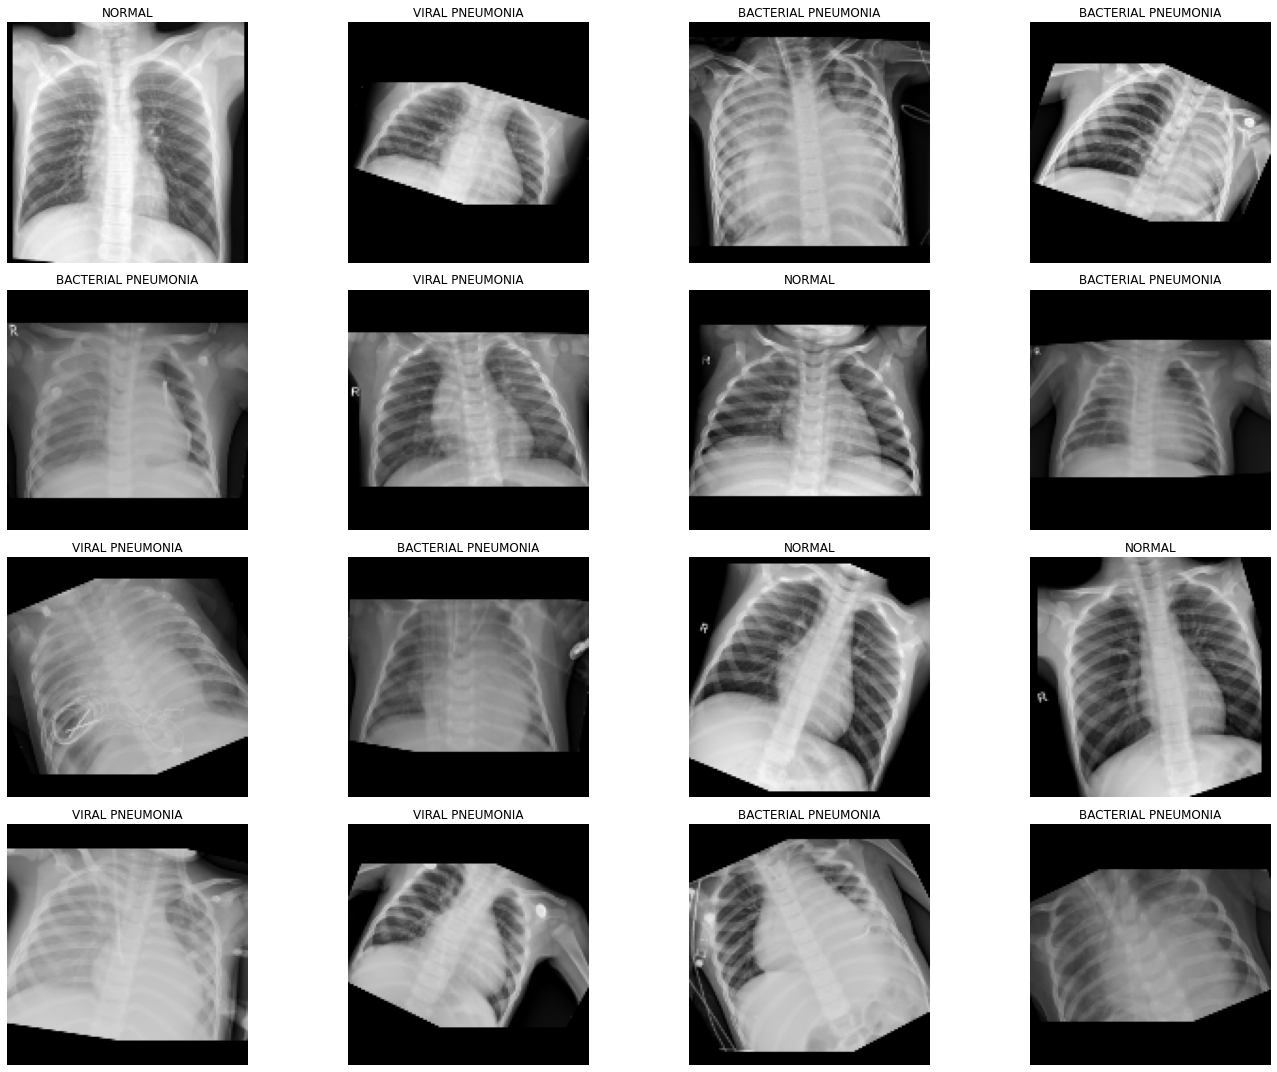

In [19]:
data.show_batch(rows=4, figsize=(20,15))

**Creating a model, finding the learning rate and running the model:**

In [0]:
learn = cnn_learner(data, models.resnet18, wd=0.1, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


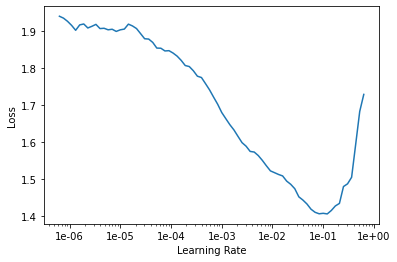

In [21]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [25]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.595863,0.592840,0.203526,02:50
1,0.589474,0.534514,0.176282,02:52
2,0.577507,0.544453,0.198718,02:51
3,0.567607,0.532368,0.201923,02:49
4,0.553215,0.529359,0.193910,02:48


In [0]:
learn.save('stage-1-128-rn18')

**Fine Tuning:**

In [27]:
learn.load('stage-1-128-rn18')

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

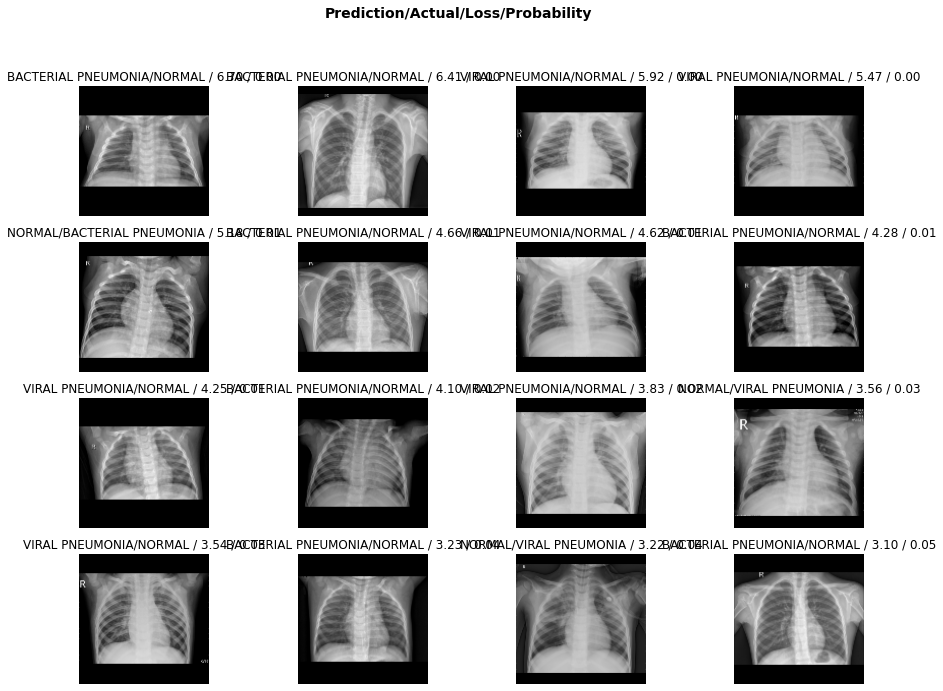

In [28]:
interp.plot_top_losses(16, figsize=(15,11))

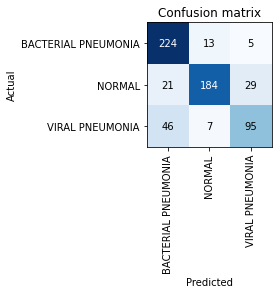

In [29]:
interp.plot_confusion_matrix()

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


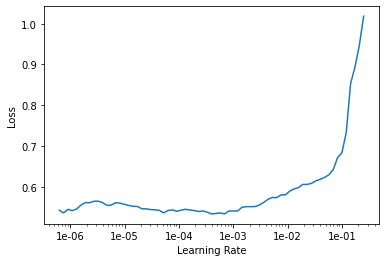

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, slice(4e-5,lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.536975,0.450492,0.145833,02:52
1,0.510824,0.371088,0.112179,02:52
2,0.464742,0.425528,0.126603,02:51
3,0.436227,0.423347,0.133013,02:52
4,0.408023,0.469574,0.150641,02:52


In [0]:
learn.save('stage-2-128-rn18')

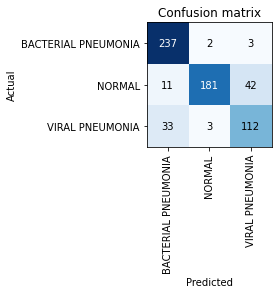

In [34]:
learn.load('stage-2-128-rn18')

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_confusion_matrix()

**Further training the model on larger images (256x256):**

In [0]:
data = (src.transform(tfms, size=256, resize_method=ResizeMethod.PAD, padding_mode = 'zeros')       
        .databunch(bs=bs)
        .normalize(imagenet_stats))  


In [0]:
learn.data = data

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


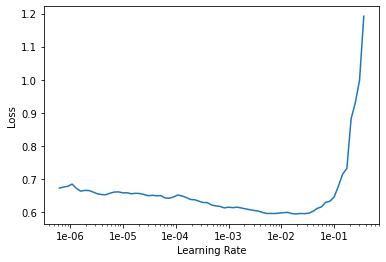

In [38]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr= 1e-3

In [40]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.607121,0.419078,0.152244,03:55
1,0.544436,0.457296,0.157051,03:53
2,0.504714,0.409298,0.136218,03:54
3,0.480355,0.436349,0.147436,03:58
4,0.469394,0.424926,0.149038,03:55


In [0]:
learn.save('stage-1-256-rn18')

In [0]:
learn.load('stage-1-256-rn18')

Learner(data=ImageDataBunch;

Train: LabelList (5232 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/gdrive/My Drive/Datasets/chest_xray_v3;

Valid: LabelList (624 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/gdrive/My Drive/Datasets/chest_xray_v3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


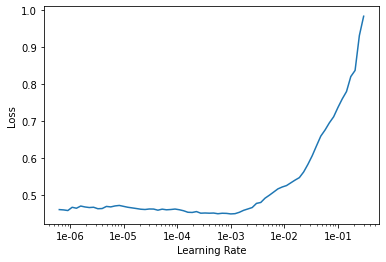

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.445512,0.500382,0.173077,03:57
1,0.434114,0.374459,0.110577,03:57
2,0.399453,0.347935,0.115385,04:00
3,0.362336,0.346592,0.105769,04:03
4,0.329465,0.389954,0.118590,04:04


In [0]:
learn.save('stage-2-256-rn18')

In [0]:
learn.load('stage-2-256-rn18')

Learner(data=ImageDataBunch;

Train: LabelList (5232 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/gdrive/My Drive/Datasets/chest_xray_v3;

Valid: LabelList (624 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/gdrive/My Drive/Datasets/chest_xray_v3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

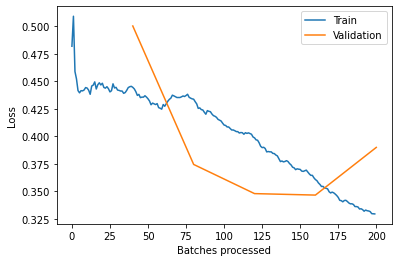

In [46]:
learn.recorder.plot_losses()

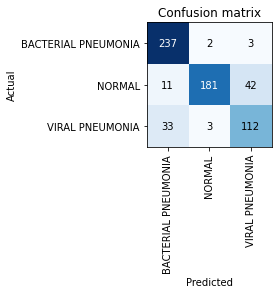

In [47]:
interp.plot_confusion_matrix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


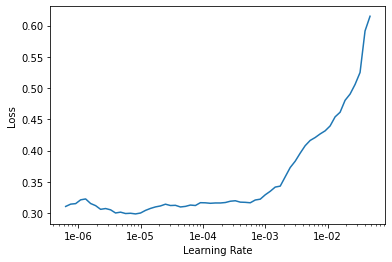

In [48]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [1]:
learn.fit_one_cycle(5, slice(2e-6, lr/10))

NameError: ignored